In [3]:
# !pip install "rtree>=0.8,<0.9"

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os

from tqdm.notebook import tqdm
from skimage.color import label2rgb
from glob import glob
%matplotlib inline

In [2]:
from labelme_utils import img_b64_to_arr
from annotations_utils import create_mask_from_points, get_random_string
from show_utils import show_image, subplot_images

## Labelme to data

In [434]:
# create directories
os.mkdir('./data/')
os.mkdir('./data/images/')
os.mkdir('./data/check_masks/')
os.mkdir('./data/pattern_masks')

annotation_paths = []
annotation_paths.extend(glob('./labelme_data/part2/*.json'))
annotation_paths.extend(glob('./labelme_data/part1/*.json'))
for annotation_path in tqdm(annotation_paths):
    with open(annotation_path) as F:
        annotation_data = json.loads(F.read())
    # convert labelme image format to np.array
    image = img_b64_to_arr(annotation_data['imageData'])
    # extract points
    check_points = [annotation['points'] for annotation in annotation_data['shapes']
                    if annotation['label'] == 'check']
    pattern_points = [annotation['points'] for annotation in annotation_data['shapes']
                      if annotation['label'] == 'pattern']
    # create image mask
    check_mask = create_mask_from_points(check_points, image.shape[:2]).clip(0, 1)
    pattern_mask = create_mask_from_points(pattern_points, image.shape[:2]).clip(0, 1)
    # save
    file_name = annotation_path.split('/')[-2] + '_' + annotation_path.split('/')[-1][:-5]
    cv2.imwrite('./data/images/' + file_name + '.jpg', image)
    cv2.imwrite('./data/check_masks/' + file_name + '.jpg', check_mask)
    cv2.imwrite('./data/pattern_masks/' + file_name + '.jpg', pattern_mask)

In [439]:
pattern_paths = glob('./data/pattern_masks/*')
for path in tqdm(pattern_paths):
    pattern_mask = cv2.imread(path, 2)
    gt_contours, hierarchy = cv2.findContours(pattern_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    gt_contours = sorted(gt_contours, key=lambda contour: cv2.contourArea(contour), reverse=True)
    contour_mask = create_mask_from_points(gt_contours[0:3], pattern_mask.shape[:2]).clip(0, 1)
    cv2.imwrite(path , contour_mask)

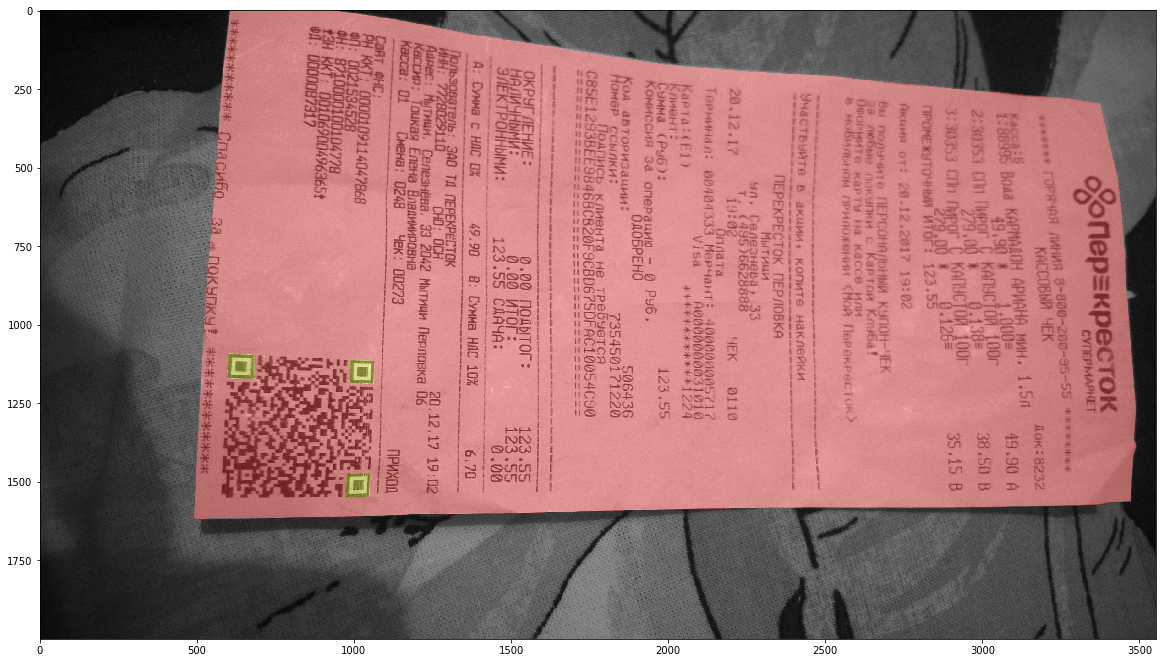

In [438]:
image = cv2.imread('./data/images/part2_0001.jpg')
check_mask = cv2.imread('./data/check_masks/part2_0001.jpg', 2)
pattern_mask = cv2.imread('./data/pattern_masks/part2_0001.jpg', 2)
show_image(label2rgb(check_mask + 2 * pattern_mask, image, bg_label=0))

### Train test split

In [3]:
from sklearn.model_selection import train_test_split

image_paths = sorted(glob('./data/images/*'))
mask_paths = sorted(glob('./data/pattern_masks/*'))
page_paths = sorted(glob('./data/check_masks/*'))

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_page_paths, test_page_paths = \
train_test_split(image_paths, mask_paths, page_paths, random_state=42, test_size=0.15)

train_image_paths, valid_image_paths, train_mask_paths, valid_mask_paths, train_page_paths, valid_page_paths = \
train_test_split(train_image_paths, train_mask_paths, train_page_paths, random_state=42, test_size=0.15)

print("train dataset size:", len(train_image_paths))
print("valid dataset size:", len(valid_image_paths))
print("test dataset size:", len(test_image_paths))

train dataset size: 67
valid dataset size: 12
test dataset size: 15


## Augmentations

In [4]:
import albumentations as albu
from albumentations.pytorch import ToTensor

def pre_transforms(image_size=640):
    return albu.Compose([
        albu.LongestMaxSize(image_size, cv2.INTER_LANCZOS4),
        albu.PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT)
    ])


def crop_transforms(size=640):
    result = albu.OneOf([albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(int(size/1.5), int(size/1.5), p=0.2),
                                       pre_transforms()]), 
           albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(size//3, size//2, p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(size//2, size//3, p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(size//2, size//2, p=0.2),
                                       pre_transforms()]),
          ], p=0.4)
    return result


def blur_transforms():
    result = [albu.Blur(p=0.1, blur_limit=7),
              albu.MedianBlur(p=0.1, blur_limit=5),
              albu.GaussianBlur(p=0.1, blur_limit=7),
              albu.MotionBlur(p=0.1, blur_limit=5),
              albu.Downscale(p=0.1, scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_LANCZOS4)]
    return result


def noise_transforms():
    result = [albu.GaussNoise(p=0.1, var_limit=(20, 80)),
              albu.JpegCompression(p=0.1, quality_lower=95),
              albu.IAAAdditiveGaussianNoise(p=0.05)]
    return result


def special_transforms():
    result = [
              albu.CLAHE(clip_limit=2, p=0.1),
              albu.IAASharpen(p=0.1),
              albu.IAAEmboss(p=0.1)
              ]
    return result


def rotate_transforms():
    result = [albu.RandomRotate90(p=0.1),
              albu.Rotate(20, p=0.2),
              albu.ShiftScaleRotate(shift_limit=0.1025, scale_limit=0.2, rotate_limit=45, p=0.1)]
    return result


def distortiot_transforms():
    result = [albu.GridDistortion(p=0.6),
              albu.IAAPiecewiseAffine(p=0.05),
              albu.OpticalDistortion(p=0.05, distort_limit=0.3, shift_limit=0.5),
              ]
    return result


def color_transforms():
    result = [albu.RandomBrightness(p=0.1),
              albu.RandomContrast(p=0.1),
              albu.RandomGamma(p=0.1),
              albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
              ]
    return result


def post_transforms():
    return [albu.Normalize(mean=0, std=1)]#, ToTensor()]


def compose(transforms_to_compose):
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


hard_transforms = compose([crop_transforms(),
                           blur_transforms(),
                           noise_transforms(),
                           special_transforms(),
                           rotate_transforms(),
                           distortiot_transforms(),
                           color_transforms()
                          ])

train_transforms = compose([
    pre_transforms(),
    hard_transforms,
    post_transforms(),
])

valid_transforms = compose([pre_transforms(), post_transforms()])

In [5]:
def invers_transformation(mask, original_shape):
    """
    invert pad/resize transform

    :param mask: np.array: binary mask
    :param original_shape: (int, int): shape of original image
    :return: np.array: new mask
    """
    scale_shape = mask.shape
    scale = max(
        original_shape[0] / scale_shape[0], original_shape[1] / scale_shape[1]
    )
    central_crop_shape = (
        int(original_shape[0] / scale),
        int(original_shape[1] / scale),
    )
    center_crop_transfrom = albu.CenterCrop(
        central_crop_shape[0], central_crop_shape[1]
    )

    revers_mask = center_crop_transfrom(image=mask, mask=mask)["mask"]

    resize_transform = albu.Resize(original_shape[0], original_shape[1])
    target_mask = resize_transform(image=revers_mask, mask=revers_mask)["mask"]
    return target_mask

## Image Blending

In [6]:
background_paths = glob('/notebook/cv_share/Backgrounds/*')

In [7]:
from blending import double_laplac_blending, _get_random_point, extract_objects_by_mask, image2background
from image_utils import cut_rectangular_image_by_mask, rotate_image


def _get_image_shape(image_shape_limit, background_shape):
    a, b = image_shape_limit
    image_shape = (b - a) * np.random.random() + a
    image_shape = image_shape * min(background_shape[:2])
    return image_shape


def _image2background(background, image, mask, angle, image_shape, num_levels=1, point=None):
    image = rotate_image(image, angle)
    mask = rotate_image(mask, angle, borderValue=0)
    image, mask = cut_rectangular_image_by_mask(image, mask, True)
    aug_pre = albu.LongestMaxSize(image_shape, interpolation=cv2.INTER_LANCZOS4)
    aug = aug_pre(image=image, mask=mask)
    image = aug['image']
    mask = aug['mask']
    if point is None:
        point = _get_random_point(background, image)
    res_image, res_mask = double_laplac_blending(background, image, mask, point, num_levels)
    return res_image, res_mask, point


def _mask2background(background, general_mask, mask, point, angle, image_shape):
    general_mask = rotate_image(general_mask, angle, 0)
    mask = rotate_image(mask, angle, borderValue=0)
    general_mask, mask = cut_rectangular_image_by_mask(general_mask, mask, True)
    aug_pre = albu.LongestMaxSize(image_shape, interpolation=cv2.INTER_NEAREST)
    aug = aug_pre(image=general_mask, mask=mask)
    general_mask = aug['image']
    mask = aug['mask']
    res_general_mask, res_mask = image2background(background, general_mask, mask, point)
    return res_general_mask, res_mask


def images2background(background, image, mask, add_mask, image_shape_limit=(0.75, 0.95),
                      num_levels=1, rotate_limits=(-180, 180)):
        
    angle = np.random.randint(rotate_limits[0], rotate_limits[1])
    image_shape = _get_image_shape(image_shape_limit, background.shape)

    res_image, res_mask, point = _image2background(background, image, mask, num_levels=num_levels, 
                                                  angle=angle, image_shape=image_shape)
    res_add_mask, _ = _mask2background(np.zeros(background.shape[:2]).astype(np.uint8), add_mask, mask,
                                       image_shape=image_shape, point=point, angle=angle)
    return res_image, res_mask, res_add_mask

In [8]:
from torch.utils.data import Dataset

class CheckDataset(Dataset):
    """
    Dataset Factory
    """
    def __init__(self, image_paths, masks_paths, transforms=None, page_paths=None,
                 background_paths=None, check_limits=(1, 4), change_background_p=0.5, to_tensor=True):
        """
        :param image_paths: list of str: image paths
        :param masks_paths: list of str: mask paths
        :param transforms: function: augmentation
        :param page_paths: list of str: page mask paths
        :param background_paths: list of str: background paths(optional)
        :param check_limits: (int, int): min and max number of check in item
        :param change_background_p: float: probability of background replacement
        :param transforms: bool: return torch.Tensor or np.array
        :return: None
        """
        self.image_paths = image_paths
        self.masks_paths = masks_paths
        self.transforms = transforms
        self.to_tensor = to_tensor
        self.page_paths = page_paths
        self.background_paths = background_paths
        self.check_limits = check_limits
        self.change_background_p = change_background_p
        
    def __len__(self):
        """
        return: int: len
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        get item for torch DataLoader
        """
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.masks_paths[idx], 2).clip(0, 1) # ToDo remove clip
        assert np.max(mask) <= 1 and np.min(mask) >= 0, 'mask must be between 0 and 1!'
        
        if self.page_paths is not None and self.background_paths is not None and \
        np.random.binomial(n=1, p=self.change_background_p):
            background_path = np.random.choice(self.background_paths)
            background = cv2.imread(background_path)
            
            page_mask = cv2.imread(self.page_paths[idx], 2).clip(0, 1)
            image, new_page_mask = cut_rectangular_image_by_mask(image, page_mask, True)
            mask = cut_rectangular_image_by_mask(mask, page_mask, False)
            image, page_mask, mask = images2background(background, image, new_page_mask, mask)
        
        
        result = {"image": image, 'mask': mask}

        if self.transforms is not None:
            result = self.transforms(**result)
        if self.to_tensor:
            result['image'] = torch.tensor(np.transpose(result['image'], axes=(2, 0, 1))).type(torch.FloatTensor)
            result['mask'] = torch.tensor(result['mask'][None, :, :]).type(torch.FloatTensor)
        return result

In [9]:
train_dataset = CheckDataset(image_paths = train_image_paths,
                             masks_paths = train_mask_paths,
                             transforms = train_transforms,
                             page_paths=train_page_paths,
                             background_paths=background_paths, change_background_p=0.5);

valid_dataset = CheckDataset(image_paths = valid_image_paths,
                             masks_paths = valid_mask_paths,
                             transforms = valid_transforms);

show_dataset = CheckDataset(image_paths = train_image_paths,
                             masks_paths = train_mask_paths,
                             transforms = train_transforms,
                             page_paths=train_page_paths,
                             background_paths=background_paths, change_background_p=0.5, to_tensor=False);

In [145]:
images_to_show = []
for i in range(8):
    result = show_dataset[0]
    images_to_show.append(label2rgb(result['mask'], result['image'],bg_label=0))

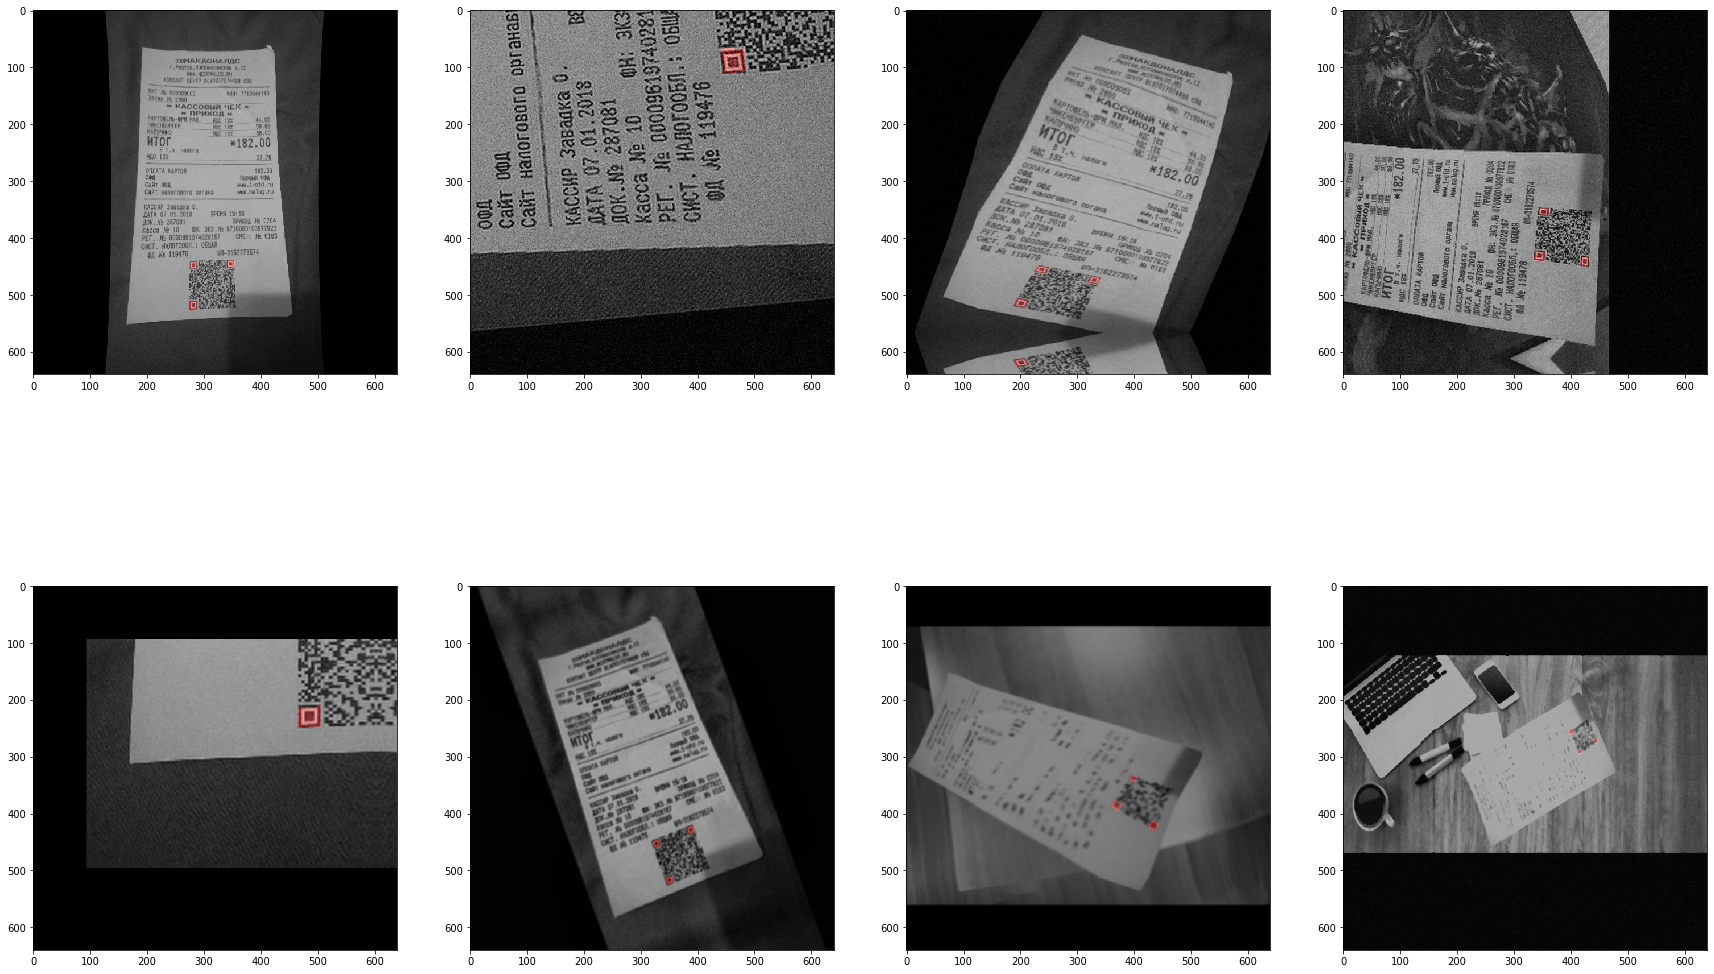

In [84]:
subplot_images(images_to_show, 3, 4, figsize=(30, 30))

In [10]:
import collections
from torch.utils.data import DataLoader

train_loader = DataLoader(
      train_dataset,
      batch_size=10, 
      shuffle=True,
      drop_last=True,
    )

valid_loader = DataLoader(
      valid_dataset,
      batch_size=10,
      shuffle=False,
      drop_last=True,
    )

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = valid_loader

### Create model and Train it

In [11]:
import segmentation_models_pytorch as smp
import torch
import catalyst

from torch import nn
from catalyst.dl import utils as catalyst_utils

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


### Create model

In [12]:
encoder_name = 'mobilenet_v2'
encoder_weights = 'imagenet'
classes = 1
in_channels = 3
model = smp.FPN(encoder_name=encoder_name, 
                encoder_weights=encoder_weights,
                in_channels=in_channels,
                classes=classes)

In [14]:
# model.load_state_dict(torch.load('./logs/mobilenet/checkpoints/best.pth')['model_state_dict']);

In [18]:
from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary

criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [19]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

model_params = catalyst_utils.process_model_params(model, layerwise_params=layerwise_params)

base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=10) # Note patience!

In [20]:
from catalyst.dl import SupervisedRunner

num_epochs = 300
logdir = "./logs/mobilenet_v2/"
device = catalyst_utils.get_device()
print(f"device: {device}")

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


In [21]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, EarlyStoppingCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    EarlyStoppingCallback(patience=21, metric='iou', minimize=False) # Note patience!
]

### Train

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

1/300 * Epoch (train): 100% 6/6 [01:01<00:00, 10.26s/it, dice=0.644, iou=0.475, loss=0.887, loss_bce=0.008, loss_dice=0.356, loss_iou=0.525]
1/300 * Epoch (valid): 100% 1/1 [00:01<00:00,  1.20s/it, dice=0.751, iou=0.601, loss=0.650, loss_bce=0.003, loss_dice=0.249, loss_iou=0.399]
[2020-04-19 20:00:07,046] 
1/300 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/300 * Epoch 1 (train): dice=0.5110 | iou=0.3504 | loss=1.1634 | loss_bce=0.0309 | loss_dice=0.4890 | loss_iou=0.6496
1/300 * Epoch 1 (valid): dice=0.7509 | iou=0.6011 | loss=0.6500 | loss_bce=0.0025 | loss_dice=0.2491 | loss_iou=0.3989
2/300 * Epoch (train): 100% 6/6 [00:58<00:00,  9.79s/it, dice=0.609, iou=0.438, loss=0.960, loss_bce=0.008, loss_dice=0.391, loss_iou=0.562]
2/300 * Epoch (valid): 100% 1/1 [00:01<00:00,  1.20s/it, dice=0.711, iou=0.552, loss=0.740, loss_bce=0.003, loss_dice=0.289, loss_iou=0.448]
[2020-04-19 20:01:07,680] 
2/300 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/300 * Epoch 2 (train): dice=0.5771 |

15/300 * Epoch (train): 100% 6/6 [00:53<00:00,  8.93s/it, dice=0.709, iou=0.549, loss=0.748, loss_bce=0.006, loss_dice=0.291, loss_iou=0.451]
15/300 * Epoch (valid): 100% 1/1 [00:01<00:00,  1.26s/it, dice=0.769, iou=0.624, loss=0.609, loss_bce=0.002, loss_dice=0.231, loss_iou=0.376]
[2020-04-19 20:13:33,038] 
15/300 * Epoch 15 (_base): lr=0.0001 | momentum=0.9000
15/300 * Epoch 15 (train): dice=0.7114 | iou=0.5533 | loss=0.7409 | loss_bce=0.0070 | loss_dice=0.2886 | loss_iou=0.4467
15/300 * Epoch 15 (valid): dice=0.7685 | iou=0.6241 | loss=0.6091 | loss_bce=0.0021 | loss_dice=0.2315 | loss_iou=0.3759
16/300 * Epoch (train): 100% 6/6 [01:06<00:00, 11.09s/it, dice=0.704, iou=0.543, loss=0.757, loss_bce=0.006, loss_dice=0.296, loss_iou=0.457]
16/300 * Epoch (valid): 100% 1/1 [00:01<00:00,  1.20s/it, dice=0.772, iou=0.629, loss=0.601, loss_bce=0.002, loss_dice=0.228, loss_iou=0.371]
[2020-04-19 20:14:41,285] 
16/300 * Epoch 16 (_base): lr=0.0001 | momentum=0.9000
16/300 * Epoch 16 (train):

### Trace model

In [29]:
# !catalyst-dl trace --logdir './logs/mobilenet/' --checkpoint 'best' --out-dir './logs/mobilenet/'\
# --out-model 'best_traced_model.pth'

### Evaluate model

In [63]:
from post_processing import MorphPostProcessing
from metrics import calculate_detection_metrics, get_detection_statistics
from shapely.geometry import Polygon

In [31]:
def make_prediction(image, model, PostProcessing, valid_transforms, threshold=0.5, output_format='mask'):
    model.eval();
    sigmoid = nn.Sigmoid()
    input_image = valid_transforms(image=image)['image']
    input_image = torch.tensor(np.transpose(input_image, axes=(2, 0, 1))).type(torch.FloatTensor)
    pred = model(input_image[None, :, :, :])
    pred = sigmoid(pred)[0, 0].detach().cpu().numpy()
    pred = (pred > threshold).astype(np.uint8)
    pred = PostProcessing.transform_mask(pred)
    pred = invers_transformation(pred, image.shape[:2])
    if output_format == 'contours':
        pred = PostProcessing.get_contours(pred)
    if output_format == 'boxes':
        pred = PostProcessing.get_boxes(pred)
    return pred

In [32]:
def min_suppression_contour_filter(contours, mask, ratio=4):
    areas = [cv2.contourArea(contour) for contour in contours]
    max_area = max(areas)
    permissible_area = max_area / ratio
    permissible_contours = list(filter(lambda contour: cv2.contourArea(contour) >= permissible_area,  contours))
    return permissible_contours

In [34]:
PostProcessing = MorphPostProcessing(kernel_size=3, opening_it=1, erosion_it=1, dilation_it=1,
                                     contour_filter=min_suppression_contour_filter)
GTPostProcessing = MorphPostProcessing(0, 0, 0, 0)
image = cv2.imread(image_path)
gt_mask = cv2.imread(mask_path, 2)
gt_boxes = GTPostProcessing.get_boxes(gt_mask)
pred_boxes = make_prediction(image, model, PostProcessing, valid_transforms, 0.5, 'boxes')

In [38]:
get_detection_statistics(pred_boxes, gt_boxes, threshold=0.4)

{'true_positive': 3, 'false_positive': 0, 'false_negative': 0}

In [68]:
test_image_paths = glob('./data/images/part2*')
test_pattern_mask_paths = glob('./data/pattern_masks/part2*')
result = {'true_positive': 0,
          'false_positive': 0,
          'false_negative': 0}
for image_path, mask_path in tqdm(zip(test_image_paths, test_pattern_mask_paths), total=len(test_image_paths)):
    image = cv2.imread(image_path)
    gt_mask = cv2.imread(mask_path, 2)
    gt_contours = GTPostProcessing.get_contours(gt_mask)
    assert len(gt_contours) == 3
    pred_contours = make_prediction(image, model, PostProcessing, valid_transforms, 0.5, 'contours')
    statistics = get_detection_statistics(pred_contours, gt_contours, 0.5, check_input=True,
                                          input_type='contour')
    result['true_positive'] += statistics['true_positive']
    result['false_positive'] += statistics['false_positive']
    result['false_negative'] += statistics['false_negative']

final_metrics = calculate_detection_metrics(**result)

In [ ]:
print('precision:', final_metrics['precision'])
print('recall:', final_metrics['recall'])
print('f_score:', final_metrics['f_score'])